<a href="https://colab.research.google.com/github/verma-saloni/Thesis-Work/blob/main/09_-6_22_wandb_tracked_politifact_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip -qq install jsonlines

In [6]:
from google.colab import drive
drive.mount('/gdrive')

from pathlib import Path
base_dir = Path("/gdrive/MyDrive/Research FakeNews")
assert base_dir.exists()

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


### Twt user graphs

In [7]:
import networkx as nx
import jsonlines

In [8]:
graph = nx.DiGraph()

In [9]:
with jsonlines.open(base_dir/"followers.jsonl") as reader:
    for line in reader:
        v = line["user_id"]
        for u in line["followers"]:
            graph.add_edge(u, v)

In [10]:
with jsonlines.open(base_dir/"following.jsonl") as reader:
    for line in reader:
        u = line["user_id"]
        for v in line["following"]:
            graph.add_edge(u, v)

In [11]:
graph.number_of_nodes(), graph.number_of_edges()

(31792, 48408)

In [12]:
followed = [n for n in graph.nodes if graph.in_degree(n)>2]
len(followed)

444

In [13]:
import random

sample_nodes = random.sample(followed, 12)
sg = graph.edge_subgraph(graph.in_edges(sample_nodes))
sg.number_of_nodes(), sg.number_of_edges()

(21, 41)

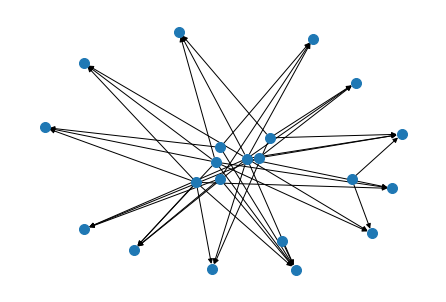

In [14]:
nx.draw(sg, node_size=100)

### Node embeddings

In [15]:
!pip install -Uqq csrgraph nodevectors

In [16]:
import csrgraph as cg
from nodevectors import Node2Vec

#### user vectors

In [17]:
n2v = Node2Vec(n_components=128, walklen=10, epochs=10)

In [18]:
n2v.fit(graph)

Making walks... 

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Done, T=4.65
Mapping Walk Names... Done, T=5.12
Training W2V... Done, T=101.47


In [19]:
n2v.predict(followed[0])

array([ 2.76751578e-01,  5.37470542e-02, -3.10383081e-01, -1.53569840e-02,
       -6.15727156e-02, -1.30085096e-01, -5.39560795e-01,  1.59271788e-02,
       -3.63354236e-01,  9.04850364e-02, -3.15886527e-01, -3.49157378e-02,
       -2.85309285e-01, -6.37377143e-01,  9.38616991e-02, -1.42329410e-01,
       -3.03182721e-01, -1.56377673e-01,  3.64720196e-01,  3.04872692e-01,
       -1.05943374e-01,  2.14770898e-01,  8.39153305e-02, -3.17197919e-01,
        9.33880210e-02,  5.73201776e-01, -1.98848307e-01,  1.57262519e-01,
       -2.15470031e-01, -7.06244335e-02, -5.16755953e-02, -4.71997768e-01,
        1.82524562e-01,  1.22295812e-01, -3.32071722e-01,  2.60672182e-01,
       -3.93539727e-01,  8.07036906e-02,  8.99263993e-02, -4.63248380e-02,
       -1.49142250e-01, -3.90988350e-01,  2.92597234e-01,  2.11950839e-01,
        2.64653027e-01,  2.61936814e-01, -2.56224275e-01, -7.30868801e-02,
       -2.46128187e-01,  3.85959782e-02, -1.14008330e-01, -3.05067539e-01,
       -6.84406579e-01,  

## user-article graph

In [20]:
import pandas as pd
import ast

In [21]:
df = pd.read_csv(base_dir/'politifact_agg.csv', index_col=0)
df.head(2)

,title,text,tweets,retweets,label,url,tweet_ids,num_retweets,log_num_retweets,num_tweets,log_num_tweets
0,Actress Emma Stone ‘For the first time in his...,NaN,[],"['1020554564334964741', '1020817527046197248',...",fake,NaN,[],2911,7.976595,0,0.0
1,Breaking President Trump makes English the of...,NaN,[],[],fake,NaN,[],0,0.000000,0,0.0


In [22]:
df['tweets'] = df.tweets.map(ast.literal_eval)

In [23]:
users_tweeted = df.tweets.map(lambda x: [int(e['user_id']) for e in x])

In [24]:
len(users_tweeted), sum(users_tweeted.map(len) > 0)

(894, 149)

In [25]:
unique_users = set()
for e in users_tweeted:
    unique_users.update(set(e))

len(unique_users)

40723

In [26]:
i = 0
for u in unique_users:
    if u in graph:
        i += 1
print(i)

756


In [27]:
users_retweeted = df.retweets.map(lambda x: [int(e) for e in ast.literal_eval(x)])

In [28]:
for e in users_retweeted:
    unique_users.update(set(e))

len(unique_users)

595543

In [29]:
i = 0
for u in unique_users:
    if u in graph:
        i += 1
print(i)

756


In [30]:
for i, l in users_tweeted.iteritems():
    if not len(l):
        continue
    a_node = f"a{i}"
    graph.add_edges_from([(a_node, u_node) for u_node in l if u_node in graph])

graph.number_of_nodes(), graph.number_of_edges()

(31896, 49576)

In [31]:
tmp = users_tweeted.map(len)
tmp.min(), tmp.mean(), tmp.max()

(0, 70.42953020134229, 21984)

## GNN

### data

In [32]:
%%capture
!pip install dgl wandb

In [33]:
import os
import jsonlines
import numpy as np
import torch
import dgl

import wandb
import IPython.display as ipd

DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [34]:
u2i = {}

follow_src = []
follow_dst = []
with jsonlines.open(base_dir/"followers.jsonl") as reader:
    for line in reader:
        v = line["user_id"]
        if v not in u2i:
            u2i[v] = len(u2i)
        for u in line["followers"]:
            if u not in u2i:
                u2i[u] = len(u2i)
            follow_src.append(u2i[u])
            follow_dst.append(u2i[v])

In [35]:
with jsonlines.open(base_dir/"following.jsonl") as reader:
    for line in reader:
        u = line["user_id"]
        if u not in u2i:
            u2i[u] = len(u2i)
        for v in line["following"]:
            if v not in u2i:
                u2i[v] = len(u2i)
            follow_src.append(u2i[u])
            follow_dst.append(u2i[v])

In [36]:
tweet_src = []
tweet_dst = []

for v, l in users_tweeted.iteritems():
    if not len(l):
        continue
    for u in l:
        if u in u2i:
            tweet_src.append(u2i[u])
            tweet_dst.append(v)

In [37]:
text_embs = np.load(base_dir/'sbert_fulltext_embeddings.npy')
text_embs.shape

(894, 768)

In [38]:
follow_src = torch.tensor(follow_src)
follow_dst = torch.tensor(follow_dst)
tweet_src = torch.tensor(tweet_src)
tweet_dst = torch.tensor(tweet_dst)

hetero_graph = dgl.heterograph({
    ('user', 'follow', 'user'): (follow_src, follow_dst),
    ('user', 'followed-by', 'user'): (follow_dst, follow_src),
    ('user', 'tweet', 'article'): (tweet_src, tweet_dst),
    ('article', 'tweeted-by', 'user'): (tweet_dst, tweet_src)})

hetero_graph.nodes['user'].data['feat'] = torch.arange(hetero_graph.num_nodes('user'))
hetero_graph.nodes['article'].data['feat'] = torch.tensor(text_embs)
hetero_graph.nodes['article'].data['label'] = torch.tensor((df.label=="real").to_numpy()).long()

In [39]:
hetero_graph.number_of_nodes(ntype='article'), hetero_graph.number_of_nodes(ntype='user')

(894, 31792)

In [40]:
# hetero_graph.nodes['article'].data['train_mask'] = torch.zeros(hetero_graph.number_of_nodes(ntype='article'), dtype=torch.bool).bernoulli(0.8)

### Model

In [41]:
def flatten_dict(d):
    for k, v in d.items():
        d[k] = v.flatten(1)
    return d

In [42]:
from collections import defaultdict
import torch.nn as nn
import torch.nn.functional as F

def _d_emb(): return 64

d_emb_dict = defaultdict(_d_emb)

In [43]:
class NodeEmbedding(nn.Module):

    def __init__(self, n_nodes, d_in, d_emb, proj_nodes=None, embed_nodes=None):
        super().__init__()
        self.proj_nodes = proj_nodes if proj_nodes is not None else list(d_in.keys())
        self.embed_nodes = embed_nodes if embed_nodes is not None else list(n_nodes.keys())
        self.emb = nn.ModuleDict({k:nn.Embedding(n_nodes[k], d_emb) for k in self.embed_nodes})
        self.proj = nn.ModuleDict({k:nn.Linear(d_in[k], d_emb, bias=False) for k in self.proj_nodes})
        self.init()

    def forward(self, nx):
        out = {}
        for k, m  in self.emb.items():
            out[k] = m(nx[k])
        for k, m  in self.proj.items():
            out[k] = m(nx[k])
        return out

    def init(self):
        for _, m in self.emb.items():
            torch.nn.init.xavier_uniform_(m.weight)
        for _, m in self.proj.items():
            torch.nn.init.xavier_uniform_(m.weight)

In [44]:
emb = NodeEmbedding({k:hetero_graph.num_nodes(k) for k in ["user"]}, {"article":text_embs.shape[1]}, 64)

In [45]:
with torch.no_grad():
    x = emb(hetero_graph.ndata['feat'])

In [46]:
for k, v in x.items():
    print(k, v.shape)

user torch.Size([31792, 64])
article torch.Size([894, 64])


In [47]:
import torch as th
from torch import nn

from dgl import function as fn
from dgl.nn.functional import edge_softmax
from dgl.base import DGLError
from dgl.nn.pytorch.utils import Identity
from dgl.utils import expand_as_pair


class GATConv(nn.Module):
    r"""

    Description
    -----------
    Apply `Graph Attention Network <https://arxiv.org/pdf/1710.10903.pdf>`__
    over an input signal.

    .. math::
        h_i^{(l+1)} = \sum_{j\in \mathcal{N}(i)} \alpha_{i,j} W^{(l)} h_j^{(l)}

    where :math:`\alpha_{ij}` is the attention score bewteen node :math:`i` and
    node :math:`j`:

    .. math::
        \alpha_{ij}^{l} &= \mathrm{softmax_i} (e_{ij}^{l})

        e_{ij}^{l} &= \mathrm{LeakyReLU}\left(\vec{a}^T [W h_{i} \| W h_{j}]\right)

    Parameters
    ----------
    in_feats : int, or pair of ints
        Input feature size; i.e, the number of dimensions of :math:`h_i^{(l)}`.
        GATConv can be applied on homogeneous graph and unidirectional
        `bipartite graph <https://docs.dgl.ai/generated/dgl.bipartite.html?highlight=bipartite>`__.
        If the layer is to be applied to a unidirectional bipartite graph, ``in_feats``
        specifies the input feature size on both the source and destination nodes.  If
        a scalar is given, the source and destination node feature size would take the
        same value.
    out_feats : int
        Output feature size; i.e, the number of dimensions of :math:`h_i^{(l+1)}`.
    num_heads : int
        Number of heads in Multi-Head Attention.
    feat_drop : float, optional
        Dropout rate on feature. Defaults: ``0``.
    attn_drop : float, optional
        Dropout rate on attention weight. Defaults: ``0``.
    negative_slope : float, optional
        LeakyReLU angle of negative slope. Defaults: ``0.2``.
    residual : bool, optional
        If True, use residual connection. Defaults: ``False``.
    activation : callable activation function/layer or None, optional.
        If not None, applies an activation function to the updated node features.
        Default: ``None``.
    allow_zero_in_degree : bool, optional
        If there are 0-in-degree nodes in the graph, output for those nodes will be invalid
        since no message will be passed to those nodes. This is harmful for some applications
        causing silent performance regression. This module will raise a DGLError if it detects
        0-in-degree nodes in input graph. By setting ``True``, it will suppress the check
        and let the users handle it by themselves. Defaults: ``False``.
    bias : bool, optional
        If True, learns a bias term. Defaults: ``True``.

    Note
    ----
    Zero in-degree nodes will lead to invalid output value. This is because no message
    will be passed to those nodes, the aggregation function will be appied on empty input.
    A common practice to avoid this is to add a self-loop for each node in the graph if
    it is homogeneous, which can be achieved by:

    >>> g = ... # a DGLGraph
    >>> g = dgl.add_self_loop(g)

    Calling ``add_self_loop`` will not work for some graphs, for example, heterogeneous graph
    since the edge type can not be decided for self_loop edges. Set ``allow_zero_in_degree``
    to ``True`` for those cases to unblock the code and handle zero-in-degree nodes manually.
    A common practise to handle this is to filter out the nodes with zero-in-degree when use
    after conv.

    Examples
    --------
    >>> import dgl
    >>> import numpy as np
    >>> import torch as th
    >>> from dgl.nn import GATConv

    >>> # Case 1: Homogeneous graph
    >>> g = dgl.graph(([0,1,2,3,2,5], [1,2,3,4,0,3]))
    >>> g = dgl.add_self_loop(g)
    >>> feat = th.ones(6, 10)
    >>> gatconv = GATConv(10, 2, num_heads=3)
    >>> res = gatconv(g, feat)
    >>> res
    tensor([[[ 3.4570,  1.8634],
            [ 1.3805, -0.0762],
            [ 1.0390, -1.1479]],
            [[ 3.4570,  1.8634],
            [ 1.3805, -0.0762],
            [ 1.0390, -1.1479]],
            [[ 3.4570,  1.8634],
            [ 1.3805, -0.0762],
            [ 1.0390, -1.1479]],
            [[ 3.4570,  1.8634],
            [ 1.3805, -0.0762],
            [ 1.0390, -1.1479]],
            [[ 3.4570,  1.8634],
            [ 1.3805, -0.0762],
            [ 1.0390, -1.1479]],
            [[ 3.4570,  1.8634],
            [ 1.3805, -0.0762],
            [ 1.0390, -1.1479]]], grad_fn=<BinaryReduceBackward>)

    >>> # Case 2: Unidirectional bipartite graph
    >>> u = [0, 1, 0, 0, 1]
    >>> v = [0, 1, 2, 3, 2]
    >>> g = dgl.heterograph({('A', 'r', 'B'): (u, v)})
    >>> u_feat = th.tensor(np.random.rand(2, 5).astype(np.float32))
    >>> v_feat = th.tensor(np.random.rand(4, 10).astype(np.float32))
    >>> gatconv = GATConv((5,10), 2, 3)
    >>> res = gatconv(g, (u_feat, v_feat))
    >>> res
    tensor([[[-0.6066,  1.0268],
            [-0.5945, -0.4801],
            [ 0.1594,  0.3825]],
            [[ 0.0268,  1.0783],
            [ 0.5041, -1.3025],
            [ 0.6568,  0.7048]],
            [[-0.2688,  1.0543],
            [-0.0315, -0.9016],
            [ 0.3943,  0.5347]],
            [[-0.6066,  1.0268],
            [-0.5945, -0.4801],
            [ 0.1594,  0.3825]]], grad_fn=<BinaryReduceBackward>)
    """
    def __init__(self,
                 in_feats,
                 out_feats,
                 num_heads,
                 feat_drop=0.,
                 attn_drop=0.,
                 negative_slope=0.2,
                 residual=False,
                 activation=None,
                 allow_zero_in_degree=False,
                 bias=True):
        super(GATConv, self).__init__()
        self._num_heads = num_heads
        self._in_src_feats, self._in_dst_feats = expand_as_pair(in_feats)
        self._out_feats = out_feats
        self._allow_zero_in_degree = allow_zero_in_degree
        if isinstance(in_feats, tuple):
            self.fc_src = nn.Linear(
                self._in_src_feats, out_feats * num_heads, bias=False)
            self.fc_dst = nn.Linear(
                self._in_dst_feats, out_feats * num_heads, bias=False)
        else:
            self.fc = nn.Linear(
                self._in_src_feats, out_feats * num_heads, bias=False)
        self.attn_l = nn.Parameter(th.FloatTensor(size=(1, num_heads, out_feats)))
        self.attn_r = nn.Parameter(th.FloatTensor(size=(1, num_heads, out_feats)))
        self.feat_drop = nn.Dropout(feat_drop)
        self.attn_drop = nn.Dropout(attn_drop)
        self.leaky_relu = nn.LeakyReLU(negative_slope)
        if bias:
            self.bias = nn.Parameter(th.FloatTensor(size=(num_heads * out_feats,)))
        else:
            self.register_buffer('bias', None)
        if residual:
            if self._in_dst_feats != out_feats * num_heads:
                self.res_fc = nn.Linear(
                    self._in_dst_feats, num_heads * out_feats, bias=False)
            else:
                self.res_fc = Identity()
        else:
            self.register_buffer('res_fc', None)
        self.reset_parameters()
        self.activation = activation

    def reset_parameters(self):
        """

        Description
        -----------
        Reinitialize learnable parameters.

        Note
        ----
        The fc weights :math:`W^{(l)}` are initialized using Glorot uniform initialization.
        The attention weights are using xavier initialization method.
        """
        gain = nn.init.calculate_gain('relu')
        if hasattr(self, 'fc'):
            nn.init.xavier_normal_(self.fc.weight, gain=gain)
        else:
            nn.init.xavier_normal_(self.fc_src.weight, gain=gain)
            nn.init.xavier_normal_(self.fc_dst.weight, gain=gain)
        nn.init.xavier_normal_(self.attn_l, gain=gain)
        nn.init.xavier_normal_(self.attn_r, gain=gain)
        if self.bias is not None:
            nn.init.constant_(self.bias, 0)
        if isinstance(self.res_fc, nn.Linear):
            nn.init.xavier_normal_(self.res_fc.weight, gain=gain)

    def set_allow_zero_in_degree(self, set_value):
        r"""

        Description
        -----------
        Set allow_zero_in_degree flag.

        Parameters
        ----------
        set_value : bool
            The value to be set to the flag.
        """
        self._allow_zero_in_degree = set_value

    def forward(self, graph, feat, get_attention=False):
        r"""

        Description
        -----------
        Compute graph attention network layer.

        Parameters
        ----------
        graph : DGLGraph
            The graph.
        feat : torch.Tensor or pair of torch.Tensor
            If a torch.Tensor is given, the input feature of shape :math:`(N, *, D_{in})` where
            :math:`D_{in}` is size of input feature, :math:`N` is the number of nodes.
            If a pair of torch.Tensor is given, the pair must contain two tensors of shape
            :math:`(N_{in}, *, D_{in_{src}})` and :math:`(N_{out}, *, D_{in_{dst}})`.
        get_attention : bool, optional
            Whether to return the attention values. Default to False.

        Returns
        -------
        torch.Tensor
            The output feature of shape :math:`(N, *, H, D_{out})` where :math:`H`
            is the number of heads, and :math:`D_{out}` is size of output feature.
        torch.Tensor, optional
            The attention values of shape :math:`(E, *, H, 1)`, where :math:`E` is the number of
            edges. This is returned only when :attr:`get_attention` is ``True``.

        Raises
        ------
        DGLError
            If there are 0-in-degree nodes in the input graph, it will raise DGLError
            since no message will be passed to those nodes. This will cause invalid output.
            The error can be ignored by setting ``allow_zero_in_degree`` parameter to ``True``.
        """
        with graph.local_scope():
            if not self._allow_zero_in_degree:
                if (graph.in_degrees() == 0).any():
                    raise DGLError('There are 0-in-degree nodes in the graph, '
                                   'output for those nodes will be invalid. '
                                   'This is harmful for some applications, '
                                   'causing silent performance regression. '
                                   'Adding self-loop on the input graph by '
                                   'calling `g = dgl.add_self_loop(g)` will resolve '
                                   'the issue. Setting ``allow_zero_in_degree`` '
                                   'to be `True` when constructing this module will '
                                   'suppress the check and let the code run.')

            if isinstance(feat, tuple):
                src_prefix_shape = feat[0].shape[:-1]
                dst_prefix_shape = feat[1].shape[:-1]
                h_src = self.feat_drop(feat[0])
                h_dst = self.feat_drop(feat[1])
                if not hasattr(self, 'fc_src'):
                    feat_src = self.fc(h_src).view(
                        *src_prefix_shape, self._num_heads, self._out_feats)
                    feat_dst = self.fc(h_dst).view(
                        *dst_prefix_shape, self._num_heads, self._out_feats)
                else:
                    feat_src = self.fc_src(h_src).view(
                        *src_prefix_shape, self._num_heads, self._out_feats)
                    feat_dst = self.fc_dst(h_dst).view(
                        *dst_prefix_shape, self._num_heads, self._out_feats)
            else:
                src_prefix_shape = dst_prefix_shape = feat.shape[:-1]
                h_src = h_dst = self.feat_drop(feat)
                feat_src = feat_dst = self.fc(h_src).view(
                    *src_prefix_shape, self._num_heads, self._out_feats)
                if graph.is_block:
                    feat_dst = feat_src[:graph.number_of_dst_nodes()]
                    h_dst = h_dst[:graph.number_of_dst_nodes()]
                    dst_prefix_shape = (graph.number_of_dst_nodes(),) + dst_prefix_shape[1:]
            # NOTE: GAT paper uses "first concatenation then linear projection"
            # to compute attention scores, while ours is "first projection then
            # addition", the two approaches are mathematically equivalent:
            # We decompose the weight vector a mentioned in the paper into
            # [a_l || a_r], then
            # a^T [Wh_i || Wh_j] = a_l Wh_i + a_r Wh_j
            # Our implementation is much efficient because we do not need to
            # save [Wh_i || Wh_j] on edges, which is not memory-efficient. Plus,
            # addition could be optimized with DGL's built-in function u_add_v,
            # which further speeds up computation and saves memory footprint.
            el = (feat_src * self.attn_l).sum(dim=-1).unsqueeze(-1)
            er = (feat_dst * self.attn_r).sum(dim=-1).unsqueeze(-1)
            graph.srcdata.update({'ft': feat_src, 'el': el})
            graph.dstdata.update({'er': er})
            # compute edge attention, el and er are a_l Wh_i and a_r Wh_j respectively.
            graph.apply_edges(fn.u_add_v('el', 'er', 'e'))
            e = self.leaky_relu(graph.edata.pop('e'))
            # compute softmax
            graph.edata['a'] = self.attn_drop(edge_softmax(graph, e))
            # message passing
            graph.update_all(fn.u_mul_e('ft', 'a', 'm'),
                             fn.sum('m', 'ft'))
            rst = graph.dstdata['ft']
            # residual
            if self.res_fc is not None:
                # Use -1 rather than self._num_heads to handle broadcasting
                resval = self.res_fc(h_dst).view(*dst_prefix_shape, self._num_heads, self._out_feats)
                rst = rst + resval
            # bias
            if self.bias is not None:
                rst = rst + self.bias.view(
                    *((1,) * len(dst_prefix_shape)), self._num_heads, self._out_feats)
            # activation
            if self.activation:
                rst = self.activation(rst)

            if get_attention:
                return rst, graph.edata['a']
            else:
                return rst


In [48]:
class GATEncoder(torch.nn.Module):

    def __init__(self, d_in, d_h, etypes, num_heads=1, dropout=0.1):
        super().__init__()
        self.conv1 = dgl.nn.HeteroGraphConv({
            rel : GATConv(d_in, d_h, num_heads, dropout, dropout,
                      residual=True, activation=nn.SELU(), 
                  ) for rel in etypes
        })
        self.conv2 = dgl.nn.HeteroGraphConv({
            rel : GATConv(d_h*num_heads, d_h, num_heads, dropout, dropout,
                      residual=True, activation=None, 
                  ) for rel in etypes
        })

    def forward(self, graph, x):
        x = flatten_dict(self.conv1(graph, x))
        x = flatten_dict(self.conv2(graph, x))
        return x

In [49]:
enc = GATEncoder(64, 64, hetero_graph.etypes)

with torch.no_grad():
    out = enc(hetero_graph, x)

for k, v in out.items():
    print(k, v.shape)

article torch.Size([894, 64])
user torch.Size([31792, 64])


In [50]:
class HetGNN(nn.Module):

    def __init__(self, g, n_nodes, d_feats, d_emb, d_h, tgt_ntype, num_heads=1):
        super().__init__()
        self.tgt_ntype = tgt_ntype
        self.emb = NodeEmbedding(n_nodes, d_feats, d_emb)
        self.encoder = GATEncoder(d_emb, d_h, g.etypes, num_heads)
        self.head = nn.Linear(d_h*num_heads, 2)

    def forward(self, graph, x):
        h = self.emb(x)
        h = self.encoder(graph, h)
        return self.head(h[self.tgt_ntype])

In [51]:
model = HetGNN(hetero_graph, {k:hetero_graph.num_nodes(k) for k in ["user"]}, {'article':text_embs.shape[1]}, 64, 64, "article")

In [52]:
with torch.no_grad():
    x = hetero_graph.ndata['feat']
    logits = model(hetero_graph, x)

logits.shape

torch.Size([894, 2])

In [53]:
def accuracy(logits, labels):
    return (logits.argmax(-1) == labels).float().mean()

In [54]:
x = hetero_graph.ndata['feat']
labels = hetero_graph.ndata['label']['article']

In [55]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(shuffle=True, random_state=124)

In [56]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

metrics = [accuracy_score, f1_score, precision_score, recall_score]
def get_name(score_func):
    return score_func.__name__.split("_")[0]

In [57]:
def train(fold, train_idx, valid_idx, params):

    model = HetGNN(hetero_graph, {k:hetero_graph.num_nodes(k) for k in ["user"]}, {'article':text_embs.shape[1]}, 64, 64, "article")
    opt = torch.optim.Adam(model.parameters(), params['lr'])

    best_acc = 0
    for epoch in range(params['n_epochs']):
        model.train()
        logits = model(hetero_graph, x)
        
        loss = F.cross_entropy(logits[train_idx], labels[train_idx])
        acc = accuracy(logits[train_idx], labels[train_idx])
        opt.zero_grad()
        loss.backward()
        opt.step()

        model.eval()
        with torch.no_grad():
            logits = model(hetero_graph, x)
            val_loss = F.cross_entropy(logits[valid_idx], labels[valid_idx])
            val_acc = accuracy(logits[valid_idx], labels[valid_idx])
        wandb.log({'train_loss':loss.item(), 'train_acc':acc, 'valid_loss':val_loss.item(), 'valid_acc':val_acc}, step=epoch)
        print(f"{epoch+1:>2}: Train loss {loss.item():.4f}, acc {acc:.4f}%; validation loss {val_loss.item():.4f}, acc {val_acc:.4f}%")

        if val_acc >= best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f'models/model-{fold}.pt')

    # load best model and evaluate
    model.load_state_dict(torch.load(f'models/model-{fold}.pt'))
    model.eval()
    with torch.no_grad():
        logits = model(hetero_graph, x)
    preds = logits[valid_idx].argmax(-1).cpu().numpy()
    targs = labels[valid_idx].cpu().numpy()
    
    eval_results = {get_name(f):f(y_pred=preds, y_true=targs) for f in metrics}
    print("Final evaluation results:")
    for k,v in eval_results.items():
        print(f"{k:<16}{v:.4f}")
    
    wandb.log(eval_results)
    wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None,
                            y_true=targs, preds=preds,
                            class_names=["Fake", "Real"])})


In [58]:
params = {
    "n_epochs":20,
    'lr':1e-2,
    "seed":124
}

x = hetero_graph.ndata['feat']
labels = hetero_graph.ndata['label']['article']

In [59]:
if not os.path.exists('models'):
    os.mkdir('models')


GROUP = "sbert-fulltext-hetgnn-ua"
for fold_id, (train_idx, valid_idx) in enumerate(skf.split(labels, labels)):
    ipd.clear_output()
    with wandb.init(entity="saloniteam", project="fnd", group=GROUP, name=f"{GROUP}-fold-{fold_id}") as run:
        train(fold_id, train_idx, valid_idx, params)


 1: Train loss 0.6919, acc 0.5209%; validation loss 0.5611, acc 0.6180%
 2: Train loss 0.5581, acc 0.6466%; validation loss 0.4725, acc 0.8483%
 3: Train loss 0.4582, acc 0.8883%; validation loss 0.4083, acc 0.8483%
 4: Train loss 0.3786, acc 0.8855%; validation loss 0.3637, acc 0.8427%
 5: Train loss 0.3197, acc 0.8925%; validation loss 0.3284, acc 0.8652%
 6: Train loss 0.2690, acc 0.9078%; validation loss 0.3079, acc 0.8876%
 7: Train loss 0.2313, acc 0.9162%; validation loss 0.3029, acc 0.8876%
 8: Train loss 0.2119, acc 0.9176%; validation loss 0.3064, acc 0.8876%
 9: Train loss 0.1915, acc 0.9260%; validation loss 0.3163, acc 0.8820%
10: Train loss 0.1737, acc 0.9330%; validation loss 0.3307, acc 0.8820%
11: Train loss 0.1625, acc 0.9399%; validation loss 0.3448, acc 0.8764%
12: Train loss 0.1505, acc 0.9427%; validation loss 0.3544, acc 0.8820%
13: Train loss 0.1398, acc 0.9497%; validation loss 0.3614, acc 0.8876%
14: Train loss 0.1337, acc 0.9483%; validation loss 0.3676, acc 

accuracy,▁
f1,▁
precision,▁
recall,▁
train_acc,▁▃▇▇▇▇▇▇▇▇██████████
train_loss,█▆▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
valid_acc,▁▇▇▇▇██████████████▇
valid_loss,█▆▄▃▂▁▁▁▁▂▂▂▃▃▃▃▃▃▄▄
accuracy,0.88764
f1,0.89474
precision,0.90426
